In [12]:
import sys
from datetime import datetime
import os
from pathlib import Path
sys.path.append(
    os.path.dirname(os.path.abspath('.'))
)
from src import QNet, agent_metrics, show_reward
### path load

import numpy as np
import torch
from torchvision import datasets
from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from shift_funcs import get_funcs, FUNCS_INVERT, ACTIONS_INVERT, FUNCS_IRREV, ACTIONS_IRREV

SEED = 0
device = 'cuda:0'

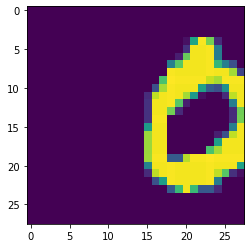

action 1 0.20449491561330413
action 2 0.23639279241108205
action 3 0.016207934154053777
action 4 0.22118055065163322
2


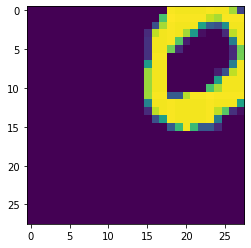

In [3]:
# 右にシフトさせたデータは左にシフトする場合が一番良い結果を返すかを確かめたかった。
# WARNING: しかし、これは可逆シフトの場合は問題である。
#          「４回」で一番MSEが小さくなるという制限をつけているため、3回で右にさらにシフトさせた方がより早くMSEが下がる場合を確かめられていなかった。
# test
tst_data = np.load('data/ur2/test_dataset.npz')
Dx = tst_data['original_dataset']
Dy = tst_data['test_dataset']
fi_N = tst_data['test_func_labels']
actions = [lambda x: x] + ACTIONS_IRREV
n = 3
x, y = Dx[n], Dy[n]
y_init = y.copy()

plt.imshow(y_init)
plt.show()
mse = []
for i in range(4):
    o = y_init.copy()
    for _ in range(4):
        o = actions[i + 1](o)
    m = np.mean((o - x)**2)
    mse.append(m)
    print('action', i + 1, m)
a = np.argmin(mse)
print(a)
o = y_init.copy()
for _ in range(4):
    o = actions[a](o)
plt.imshow(o)
plt.show()

In [5]:
# 4回でMSEが最小のものは、自分が想定している対(上(0)で変換すれば下(1), 右(3)で変換すれば左(2))と同じかを確認した。
# しかし、これも上のセルと同様に「４回」逆変換を施す場合でのMSE最小の行動しか調べていないので、正しい確認になっていない。
# 実際,右(3)の変換に対しては、もう一度右(3)を3回適応した方がより早くMSEが0になる。
err = 0
N = fi_N.shape[0]
for n in range(N):
    fi = fi_N[n]
    expected_a_t = 1 if fi == 0 else 2
    x, y = Dx[n], Dy[n]
    y_init = y.copy()
    mse = []
    for a in range(1, 5):
        o = y_init.copy()
        for _ in range(4):
            o = actions[a](o)
        mse.append(np.mean((o - x)**2))
    a_t = np.argmin(mse)
    if a_t != expected_a_t:
        err += 1
err / N

0.0

In [32]:
# 可逆でのMSE
SEED = 0
data_dir = 'udlr8_invert'
outdir = 'udlr8_invert'
FUNCS = FUNCS_INVERT
ACTIONS = ACTIONS_INVERT
candy = [0, 1, 2, 3, 4]

for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    Dy = torch.from_numpy(Dy)

    print('init mse', torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy, Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    
    ### ランダムにフィルタを選択した場合
    
    mse_means = []
    for itr in range(100):
        np.random.seed(itr)
        idx_N = np.random.choice(candy, (Dy.shape[0], 5))
        mse_random = []
        for n in range(Dy.shape[0]):
            idx_n = idx_N[n]
            xn = Dx[n]
            yn = Dy[n]
            for i in idx_n:
                yn = actions[i](yn)
            mse_random.append(
                torch.mean((yn - xn)**2).item()
            )
        mse_random = np.array(mse_random)
        mse_means.append(mse_random.mean())
    mse_means = np.array(mse_means)
    print('random mse mean = ', mse_means.mean(), 'std', mse_means.std())

2 channel weight: =  0.05
RESULT_PATH results/udlr8_invert/channel02_weight005_seed00
TEST_DATASET_PATH data/udlr8_invert/test_dataset.npz
init mse 0.1795181542264047
MODEL_PATH results/udlr8_invert/channel02_weight005_seed00/Qnet020000.pth
MSE(test_dataset, agent_outputs) =  0.14753298607419707
random mse mean =  0.1796704194036438 std 0.0002519980594862038


In [107]:
# 不可逆でのMSE
SEED = 0
data_dir = 'udlr8_irrev'
outdir = 'udlr8_prod_reward'
FUNCS = FUNCS_IRREV
ACTIONS = ACTIONS_IRREV
candy = [0, 1, 2, 3, 4]

for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    Dy = torch.from_numpy(Dy)

    print('init mse', torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy, Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    
    ### ランダムにフィルタを選択した場合
    
    mse_means = []
    for itr in range(100):
        np.random.seed(itr)
        idx_N = np.random.choice(candy, (Dy.shape[0], 5))
        mse_random = []
        for n in range(Dy.shape[0]):
            idx_n = idx_N[n]
            xn = Dx[n]
            yn = Dy[n]
            for i in idx_n:
                yn = actions[i](yn)
            mse_random.append(
                torch.mean((yn - xn)**2).item()
            )
        mse_random = np.array(mse_random)
        mse_means.append(mse_random.mean())
    mse_means = np.array(mse_means)
    print('random mse mean = ', mse_means.mean(), 'std', mse_means.std())

2 channel weight: =  0.05
RESULT_PATH results/udlr8_prod_reward/channel02_weight005_seed00
TEST_DATASET_PATH data/udlr8_irrev/test_dataset.npz
init mse 0.16546874889760238
MODEL_PATH results/udlr8_prod_reward/channel02_weight005_seed00/Qnet020000.pth
MSE(test_dataset, agent_outputs) =  0.1255029964488175
random mse mean =  0.15309297424787563 std 0.000815454525587718


2 channel weight: =  0.05
RESULT_PATH results/udlr8_prod_reward/channel02_weight005_seed00


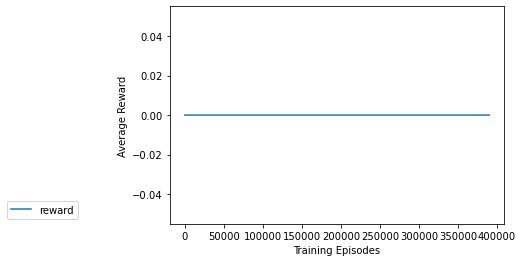

TEST_DATASET_PATH data/udlr8_irrev/test_dataset.npz
0.16546874889760238
MODEL_PATH results/udlr8_prod_reward/channel02_weight005_seed00/Qnet020000.pth
MSE(test_dataset, agent_outputs) =  0.1255029964488175


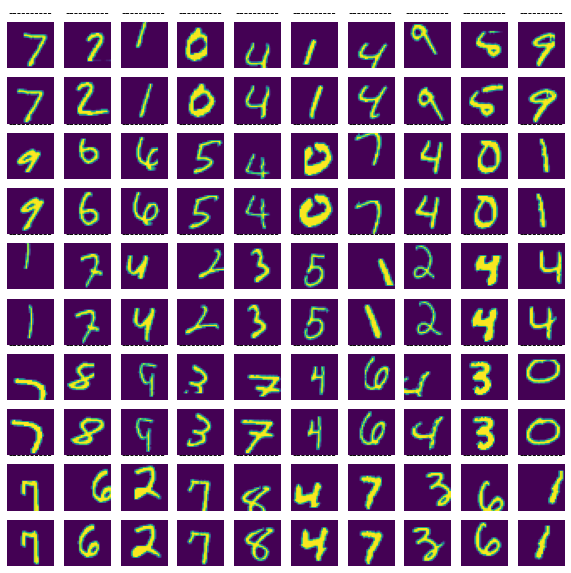

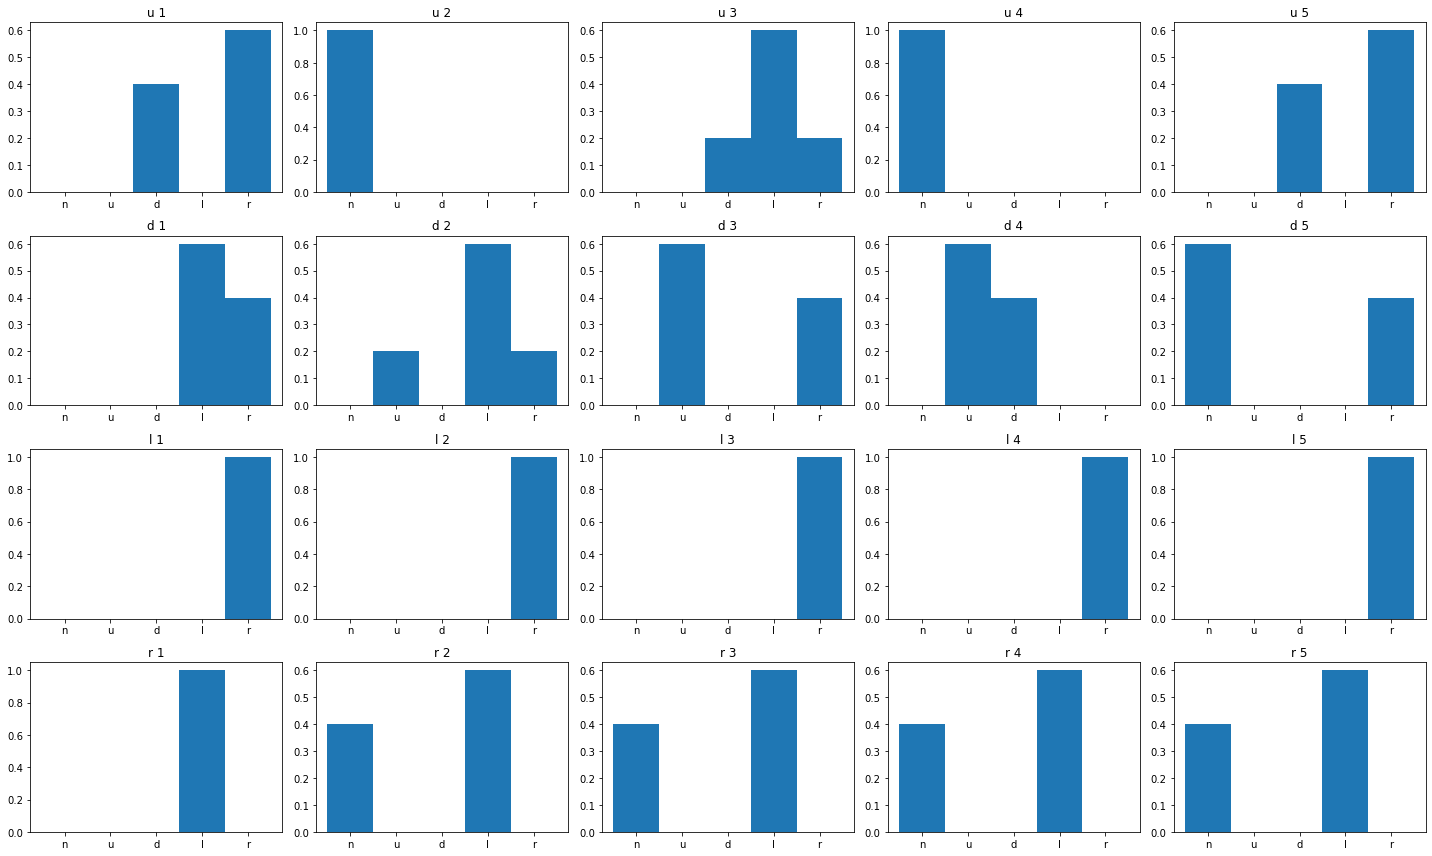


--------------------



In [106]:
# 実験条件を指定
SEED = 0
data_dir = 'udlr8_irrev'
outdir = 'udlr8_prod_reward'
FUNCS = FUNCS_IRREV
ACTIONS = ACTIONS_IRREV

for (CHANNEL, WEIGHT) in [
#     [2, 0.00],
    [2, 0.05],
]:
    print(CHANNEL, 'channel', 'weight: = ', WEIGHT)
    RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (CHANNEL, int(100*WEIGHT), SEED))
    print("RESULT_PATH", str(RESULT_PATH))

    funcs = FUNCS
    actions = [lambda x: x] + ACTIONS

    # see reward
    fig = plt.figure()
    ax = plt.subplot(111)
    ma = show_reward(ax, dir_path=str(RESULT_PATH), mono=False, n=10000, label='reward')
    plt.show()
    fig.savefig(os.path.join(RESULT_PATH, 'reward.png'))

    # load test data
    TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
    print("TEST_DATASET_PATH", TEST_DATASET_PATH)
    test_dataset_context = np.load(TEST_DATASET_PATH)
    Dx = test_dataset_context['original_dataset']
    Dx = torch.from_numpy(Dx)
    Dy = test_dataset_context['test_dataset']
    labels = test_dataset_context['test_func_labels']
    Dy = torch.from_numpy(Dy)

    print(torch.mean((Dy - Dx)**2).item())
    # load model
    Qnet = QNet(c=CHANNEL, m=[20, 20, len(actions)])
    MODEL_PATH = RESULT_PATH / 'Qnet020000.pth'
    print('MODEL_PATH', str(MODEL_PATH))
    Qnet.load_state_dict(
        torch.load(str(MODEL_PATH))
    )
    
    METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
    if len(METRIC_PATH) > 0:
        result = np.load(str(METRIC_PATH[0]))
    else:
        result = agent_metrics(Dy.clone(), Dx, Qnet, actions, channel=CHANNEL)
    mse = result[:, -1].mean()
    print('MSE(test_dataset, agent_outputs) = ', mse)
    
    # 復元画像を保存
    SNAPSHOT_PATH = os.path.join(RESULT_PATH, 'snapshot')
    os.makedirs(SNAPSHOT_PATH, exist_ok=True)
    fig, axes = plt.subplots(10, 10, figsize=(10, 10))
    for i in range(0, 10, 2):
        for j in range(10):
            y = Dy[10 * i + j].clone()
            x = Dx[10 * i + j]
            took_act = result[10 * i + j, :-1]
            for a in took_act:
                y = actions[int(a)](y)
            x_hat = y
            
            axes[i, j].imshow(x_hat)
            axes[i, j].axis('off')
            axes[i, j].set_title('-' * 10)
            axes[i + 1, j].imshow(x)
            axes[i + 1, j].axis('off')
    plt.show()
    timestamp = datetime.strftime(datetime.now(), '%m%d_%H%M%S')
    restore_imgs_fname = os.path.join(SNAPSHOT_PATH, f'restore_imgs_{timestamp}.png')
    fig.savefig(restore_imgs_fname)
    
    # 選択した行動のヒストグラムを保存
    # TODO: 入力画像の4通りの変換で場合分け
    fig, axes = plt.subplots(4, 5, figsize=(20, 12))
    for i in range(4):
        act_hist = result[labels == i, :-1]
        for j in range(5):
            axes[i, j].set_title('%s %d' % (list('udlr')[i], j + 1))
            freq, _, patches = axes[i, j].hist(act_hist[j], bins=np.arange(6) - 0.5, density=True)
#             patches[freq.argsort()[::-1][0]].set_fc('r')
#             patches[freq.argsort()[::-1][1]].set_fc('r')
            axes[i, j].set_xticks(np.arange(5))
            axes[i, j].set_xticklabels(list('nudlr'))
    plt.tight_layout()
    plt.show()
    took_actions_fname = os.path.join(SNAPSHOT_PATH, f'took_actions_{timestamp}.png')
    fig.savefig(took_actions_fname)
    print()
    
    # 上下左右

    if len(METRIC_PATH) == 0:
        np.save(str(RESULT_PATH / f'metrics{int(1000*mse):03d}.npy'), result)
    print('-' * 20)
    print()

In [88]:
### 画像を追い出した場合と右の画像に対して選択された場合を比較する。
TEST_DATASET_PATH = 'data/%s/test_dataset.npz' % data_dir
test_context = np.load(TEST_DATASET_PATH)
Dx = test_context['original_dataset']
Dy = test_context['test_dataset']
ideal_action_N = np.array(test_context['ideal_actions']) + 1
labels = test_context['test_func_labels']

RESULT_PATH = Path('results/%s' % outdir) / ('channel%02d_weight%03d_seed%02d' % (2, int(100*0.05), SEED))
METRIC_PATH = list(RESULT_PATH.glob('metrics*.npy'))
result = np.load(str(METRIC_PATH[0]))
actions = [lambda x:x] + ACTIONS_IRREV

In [90]:
### 理想的な選択肢を選べているか

N = Dx.shape[0]
count = 0
for n in range(N):
    an_expected = (ideal_action_N[n]).astype(np.int)
    an_agent = (result[n, :-1]).astype(np.int)
    an_agent = an_agent[an_agent != 0]
    if an_expected.size != an_agent.size:
        continue
    if np.allclose(an_expected, an_agent):
        count += 1
count

0

In [84]:
### 追い出した方が得か、理想的な復元の方が得か
### 「得」 == MSEが小さくなる
total = 0
count = 0
inv = [1, 0, 3, 2]
for n in range(result.shape[0]):
    a_n = result[n, :-1]
    y_n = Dy[n]
    x_n = Dx[n]
    fi_n = labels[n]
    y1 = y_n.copy()
    for a in a_n:
        y1 = actions[int(a)](y1)
    if np.sum(y1) != 0:
        continue
    total += 1
    y2 = y_n.copy()
    for _ in range(4):
        y2 = actions[inv[fi_n]](y2)
    mse1 = np.mean((y1 - x)**2)  #エージェントが追い出した画像
    mse2 = np.mean((y2 - x)**2)  #想定される変換によって作成した画像
    if mse1 < mse2:
        count += 1
print('出力が0の画像の件数:', total)
print('追い出した方が得の画像の件数:', count)

出力が0の画像の件数: 316
追い出した方が得の画像の件数: 302
